In [1]:
import sys
if "../src" not in sys.path:
    sys.path.append("../../src")
    
import json
import pandas as pd
from pathlib import Path
from itertools import chain
from typing import cast, Dict
from tqdm.auto import tqdm
import numpy as np
from praatio import textgrid
from weave import Utterance, Speech, BuildUtt

In [2]:
from weave import MfaAgent
CORPUS_NAME = "xianzai"
mfa_dir = Path(f"~/Documents/MFA/{CORPUS_NAME}").expanduser()
agent = MfaAgent(str(mfa_dir), CORPUS_NAME, 
                 speech_json_dir="../../data/aligned_xianzai/mfa_json")

STDERR: gmm-copy --binary=false /home/seantyh/Documents/MFA/xianzai/alignment/final.mdl - 
LOG (gmm-copy[5.5.1068]:main():gmmbin/gmm-copy.cc:75) Written model to -



In [ ]:
pmat_list = []
utt_segs = []
cur = 0
for speech_idx, speech_x in enumerate(tqdm(agent.speeches)):
    utt_x = speech_x.utterances[0]
    word_x = utt_x.words[0]
    mfa_uttid = agent.wav2uttid[utt_x.utt_id]
    lgmmprob, feat_mat = agent.compute_gmm(mfa_uttid, return_features=True)
    pmat_list.append(lgmmprob)
    utt_segs.append((cur, cur + lgmmprob.shape[0]))
    if len(pmat_list) > 200:
        break

In [4]:
pmat = np.vstack(pmat_list)

## Play around with the pmat

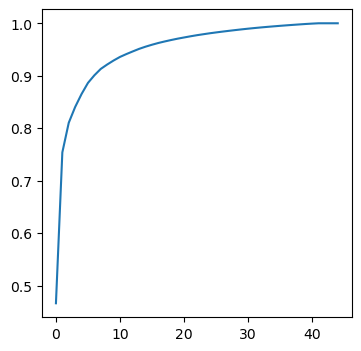

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(pmat)
plt.figure(figsize=(4, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))



In [6]:
pca = PCA(n_components=10)
pca.fit(pmat)
proj = pca.transform(pmat)
compo = pca.components_
compo.shape

(10, 45)

In [7]:
c2 = compo[:2, :]
c2.shape

(2, 45)

In [8]:
phones = agent.phone_table

### Compo 0 vs 1

In [9]:
def plot_compo(idx1, idx2):
  plt.plot(compo[idx1, :], compo[idx2, :], '.')
  for phone_i, phone_x in enumerate(phones):
    plt.text(compo[idx1, phone_i], compo[idx2, phone_i], phone_x)
  plt.axvline(0, color='.6', lw=1)
  plt.axhline(0, color='.6', lw=1)
  plt.xlabel("Compo {}".format(idx1))
  plt.ylabel("Compo {}".format(idx2))
  plt.title("Compo {} vs {} (xianzai 200 toks)".format(idx1, idx2))

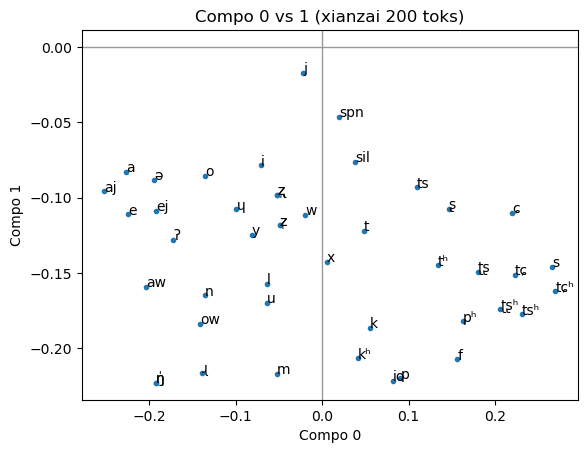

In [10]:
plot_compo(0, 1)

Text(0.5, 1.0, 'Compo 2 vs 1 \n(Compo0 > 0, xianzai 200 toks)')

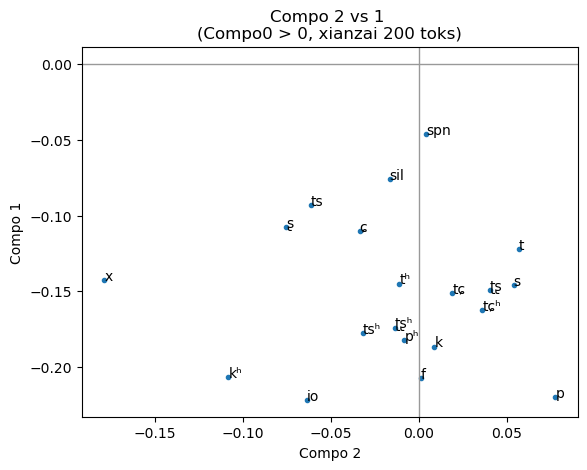

In [12]:
idx1 = 2
idx2 = 1
mask = compo[0, :]>0
plt.plot(compo[idx1, mask], compo[idx2, mask], '.')
for phone_i, phone_x in enumerate(phones):
  if not mask[phone_i]: continue
  plt.text(compo[idx1, phone_i], compo[idx2, phone_i], phone_x)
plt.axvline(0, color='.6', lw=1)
plt.axhline(0, color='.6', lw=1)
plt.xlabel("Compo {}".format(idx1))
plt.ylabel("Compo {}".format(idx2))
plt.title("Compo {} vs {} \n(Compo0 > 0, xianzai 200 toks)".format(idx1, idx2))